In [42]:
%matplotlib inline
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import phasekick as pk
from scipy.misc import derivative
import sigutils
from sigutils._util import lin_or_logspace
from munch import Munch
from tqdm import tqdm

def d2(x, dx=1.0):
    d = np.zeros(x.size)
    d[1:-1] = (x[2:] + x[0:-2] - 2 * x[1:-1]) / dx**2
    d[0] = (2*x[1] - 2 * x[0]) / dx**2
    d[-1] = (x[-2] - 2 * x[-1]) / dx**2
    return d

def run_heat_eq(dx, dt, Nx, NT, glass):
    x = np.arange(Nx) * dx * 1e6
    alpha = glass.kappa / (glass.rho * glass.cp) * dt / dx**2
    xt = np.zeros((NT, x.size))
    g = glass.g * dt / dx
    for i in tqdm(xrange(1, NT)):
        xt[i] = xt[i-1] + alpha * d2(xt[i-1])
        xt[i, 0] += g
    
    return x, xt

def heat_layer(dx, dt, Nx, Nt, glass, sample, Nsave=1000):
    x = np.arange(Nx) * dx * 1e6 - sample.thickness*1e6
    alpha_glass = glass.kappa / (glass.rho * glass.cp) * dt / dx**2
    alpha_sample = sample.kappa / (sample.rho * sample.cp) * dt / dx**2
    alpha = np.where(x <= 0, alpha_sample, alpha_glass)
    print(np.max(alpha))
    g = np.where(x <= 0, sample.g * dt, 0)
    xt_prev = np.zeros(x.size)
    xt = np.zeros((Nt//Nsave+1, x.size))
    xt[0] = xt_prev
    for i in tqdm(xrange(1, Nt)):
        xt_curr = xt_prev + alpha * d2(xt_prev) + g
        if (i % Nsave) == 0:
            xt[i//Nsave] = xt_curr
        xt_prev = xt_curr
    
    return x, xt

def log_pts_with_zero(x, N, axis=0):
    pts = [0]
    pts.extend(np.array(lin_or_logspace(1, x.shape[axis]-1, N, True), np.int))
    return pts

In [43]:
sample = Munch(cp=1500, rho=1330, kappa=0.2, thickness=100e-9, A=(120e-6 * 330e-6), P = 3e-3)
sample.g = sample.P / (sample.A * sample.rho * sample.cp * sample.thickness)
g = P/(A * rho * cp)
glass = Munch(rho=2400, cp=840, kappa=1.0, g=g)

Let's discretize in $t$, $x$ using $\Delta t = 1 \: \mathrm{µs}$, $\Delta x = 1 \mathrm{µm}$.

In [44]:
cp = 1500
rho = 1330
kappa = 0.2
P = 3e-3
A = (120e-6 * 330e-6)
alpha = kappa / (rho * cp)

# alpha_unitless = alpha * dt / dx**2

In [54]:
x, xt = heat_layer(2e-8, 3e-10, 10000, 10000000, glass, sample, Nsave=5000)

  0%|          | 2134/9999999 [00:00<15:50, 10517.38it/s]

0.372023809524


100%|█████████▉| 9999273/9999999 [15:59<00:00, 9323.07it/s]

ValueError: I/O operation on closed file

In [48]:
np.arange(xt.size) * 3e-10 * 1000

array([  0.00000000e+00,   3.00000000e-07,   6.00000000e-07, ...,
         6.00599100e-01,   6.00599400e-01,   6.00599700e-01])

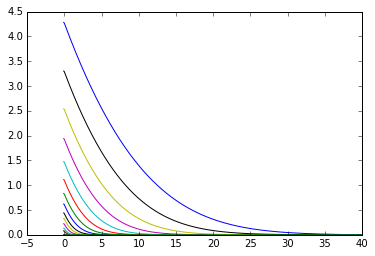

In [58]:
for i in log_pts_with_zero(xt, 15):
    plt.plot(x, xt[i])

In [21]:
g = P/(A * rho * cp)
glass = Munch(rho=2400, cp=840, kappa=1.0, g=g)

In [22]:
dx1 = 1.0e-7
dt1 = 0.5e-8
Nx1 = int(100e-6/dx1)
Nt1 = int(3e-3/dt1)

In [23]:
x1, xt1 = run_heat_eq(dx, dt, Nx1, Nt1, glass)

100%|██████████| 599999/599999 [00:55<00:00, 10787.59it/s]


In [24]:
dx2 = 1.5e-7
dt2 = 0.3e-8
Nx2 = int(200e-6/dx2)
Nt2 = int(3e-3/dt2)
x2, xt2 = run_heat_eq(dx2, dt2, Nx2, Nt2, glass)


100%|██████████| 999999/999999 [03:34<00:00, 4653.28it/s]


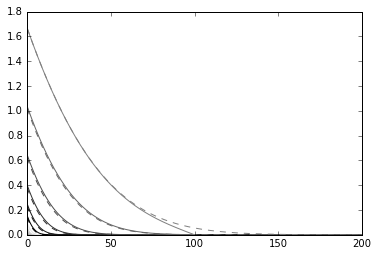

In [25]:
pts = [0]
pts.extend(np.array(lin_or_logspace(1, Nt1-1, 15, True), np.int))
pts2 = [0]
pts2.extend(np.array(lin_or_logspace(1, Nt2-1, 15, True), np.int))
i = 0
for i1, i2 in zip(pts, pts2):
    plt.plot(x1, xt1[i1], "{:.1f}".format(((i) % 10)/10.0))
    plt.plot(x2, xt2[i2], "{:.1f}".format(((i) % 10)/10.0), linestyle='--')
    i += 1
    

- Dimensionality looks good

In [27]:
glass

Munch({'cp': 840, 'kappa': 1.0, 'g': 0.0379737221842485, 'rho': 2400})

In [29]:
(glass.kappa / (glass.rho * glass.cp)) / (100e-6)**2

49.6031746031746

In [30]:
glass

Munch({'cp': 840, 'kappa': 1.0, 'g': 0.0379737221842485, 'rho': 2400})